# 18 LightGBM
[목적]
  - XGBoost Model에서 Feature와 Data를 Handling 하여 처리해주는 LightGBM Model 실습 및 해석
  - LightGBM의 경우 Missing Value를 Model 자체 내에서 처리해주기 때문에 삭제하지 않아도 됨
  - Big Data를 빠르게 학습함
  - 논문에서는 데이터 10,000개 이상일 때 사용하라고 했지만, 일단 돌려보자

[Process]
  1. Define X's & Y
  2. Split Train & Valid dataset
  3. Modeling
  4. Model 해석

In [2]:
import os
import gc
import re
import pickle
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter

In [3]:
# Data Loading (수술 時 사망 데이터)
data_df=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [5]:
data_df.describe()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


In [6]:
# Data Quality Checking
col = []
missing = []
level = []
for name in data_df.columns:

    # Missing
    missper = data_df[name].isnull().sum() / data_df.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data_df[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']),
                     pd.DataFrame(missing, columns=['Missing Percentage']),
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data_df.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data_df.shape))

>>>> Data Shape : (532, 22)


In [7]:
# X's & Y Split
y = data_df['censor']
X = data_df.drop(columns=['censor'])

In [8]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


[LightGBM Parameters]
  - Package : https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
  - learning_rate : GBM에서 shrinking 하는 것과 같은 것
  - reg_lambda : L2 regularization term on weights (analogous to Ridge regression)
  - reg_alpha : L1 regularization term on weight (analogous to Lasso regression)
  - objective
        objective 🔗︎, default = regression, type = enum, options: regression, regression_l1, huber, fair, poisson, quantile, mape, gamma, tweedie, binary, multiclass, multiclassova, cross_entropy, cross_entropy_lambda, lambdarank, rank_xendcg, aliases: objective_type, app, application, loss

  - eval_metric [ default according to objective ]
    - The metric to be used for validation data.
    - The default values are rmse for regression and error for classification.
    - Typical values are:
        -    rmse – root mean square error
        -    mae – mean absolute error
        -    logloss – negative log-likelihood
        -    error – Binary classification error rate (0.5 threshold)
        -    merror – Multiclass classification error rate
        -    mlogloss – Multiclass logloss
        -    auc: Area under the curve

[LightGBM]

  - Hyperparameter tuning
  - n_estimators, learning_rate, max_depth, reg_alpha
  - LightGBM은 Hyperparam이 굉장히 많은 알고리즘 중에 하나임
  - 위에 4가지만 잘 조정해도 좋은 결과를 얻을 수 있음

In [9]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

In [10]:
# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
f1_score_ = []

In [12]:
cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:

                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = LGBMClassifier(n_estimators=n, learning_rate=l,
                                       max_depth=m, reg_alpha=L1,
                                       n_jobs=-1, objective='cross_entropy')
                model.fit(X.iloc[train_idx], y.iloc[train_idx])


                # Train Acc
                y_pred_train = model.predict(X.iloc[train_idx])
                cm_train = confusion_matrix(y.iloc[train_idx], y_pred_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
                print("Train F1-Score : {}".format(f1_score(y.iloc[train_idx], y_pred_train)))

                # Test Acc
                y_pred_test = model.predict(X.iloc[valid_idx])
                cm_test = confusion_matrix(y.iloc[valid_idx], y_pred_test)
                print("Test Confusion Matrix")
                print(cm_test)
                print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
                print("Test F1-Score : {}".format(f1_score(y.iloc[valid_idx], y_pred_test)))
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                f1_score_.append(f1_score(y.iloc[valid_idx], y_pred_test))


                #joblib.dump(model, './LightGBM_model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(save_acc[-1], 4)))
                #gc.collect()

>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
Train Confusion Matrix
[[237   4]
 [ 55  76]]
Train Acc : 0.8413978494623656
Train F1-Score : 0.7203791469194314
Test Confusion Matrix
[[103   7]
 [ 10  40]]
TesT Acc : 0.89375
Test F1-Score : 0.8247422680412372
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.3
Train Confusion Matrix
[[237   4]
 [ 54  77]]
Train Acc : 0.8440860215053764
Train F1-Score : 0.7264150943396226
Test Confusion Matrix
[[102   8]
 [ 10  40]]
TesT Acc : 0.8875
Test F1-Score : 0.816326530612245
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.5
Train Confusion Matrix
[[237   4]
 [ 54  77]]
Trai

In [13]:
print(f">>> {np.argmax(f1_score_)} <<<\nBest Test f1-score : {f1_score_[np.argmax(f1_score_)]}\nBest n_estimators : {save_n[np.argmax(f1_score_)]}\nBest Learning Rate : {save_l[np.argmax(f1_score_)]}\nBest Max_depth : {save_m[np.argmax(f1_score_)]}\nBest L1-norm : {save_L1[np.argmax(f1_score_)]}")

>>> 7 <<<
Best Test f1-score : 0.8672566371681417
Best n_estimators : 5
Best Learning Rate : 0.3
Best Max_depth : 3
Best L1-norm : 0.3


In [14]:
best_model = LGBMClassifier(n_estimators=save_n[np.argmax(f1_score_)], learning_rate=save_l[np.argmax(f1_score_)],
                           max_depth=save_m[np.argmax(f1_score_)], reg_alpha=save_L1[np.argmax(f1_score_)], objective='cross_entropy',
                           random_state=119)
best_model.fit(X.iloc[train_idx], y.iloc[train_idx])

LGBMClassifier(learning_rate=0.3, max_depth=3, n_estimators=5,
               objective='cross_entropy', random_state=119, reg_alpha=0.3)

In [18]:
# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(y.iloc[train_idx], y_pre_train)))

Train Confusion Matrix
[[228  13]
 [ 19 112]]
Train Acc : 0.9139784946236559
Train F1-Score : 0.875


In [20]:
# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(y.iloc[valid_idx], y_pre_test)))

Test Confusion Matrix
[[96 14]
 [ 1 49]]
TesT Acc : 0.90625
Test F1-Score : 0.8672566371681417


In [21]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

    Score  Feature
0      10    event
1       4    cd496
2       4    cd420
3       4     cd40
4       3  preanti
5       2     wtkg
6       2     race
7       1      z30
8       1      age
9       0  symptom
10      0    strat
11      0     str2
12      0        r
13      0   oprior
14      0   karnof
15      0     homo
16      0     hemo
17      0   gender
18      0    drugs
19      0    cd820
20      0     cd80


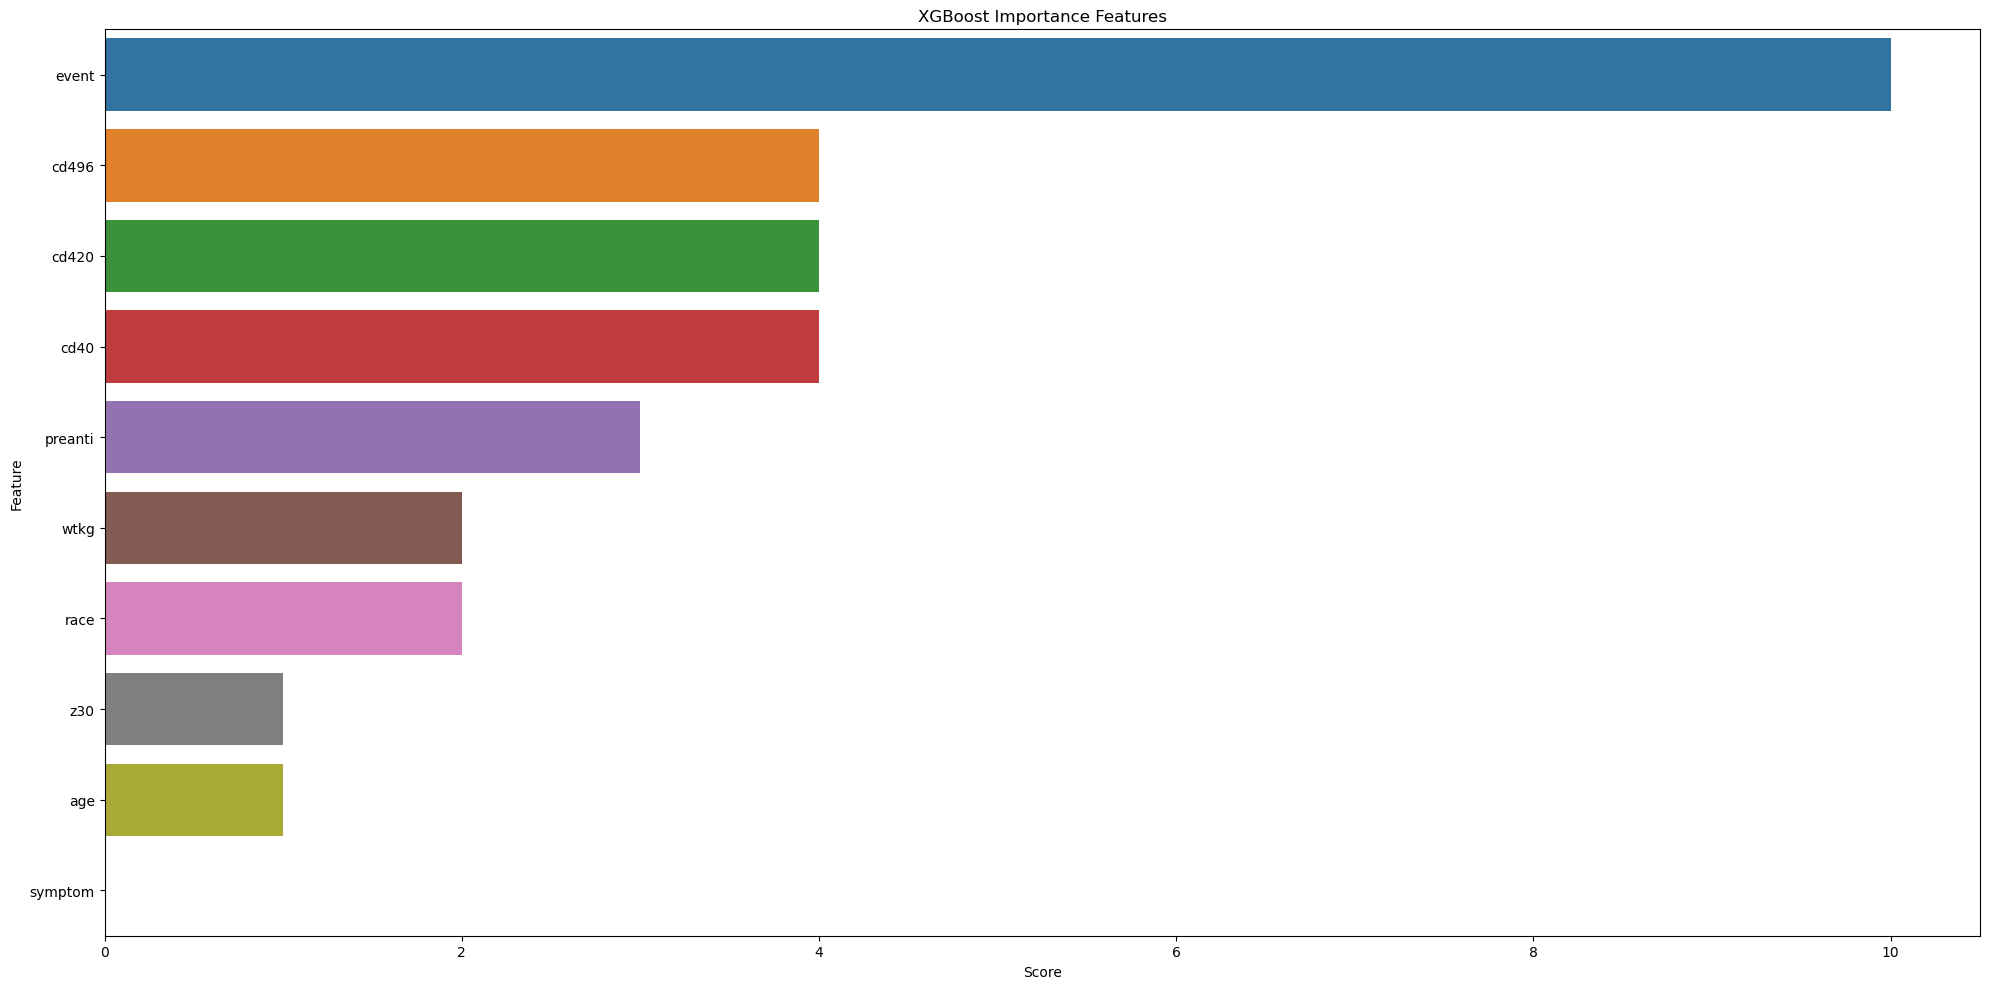

In [22]:
# Importance Score Top 10
feature_map_10 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_10.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('XGBoost Importance Features')
plt.tight_layout()
plt.show()